

# Project: How education impacts in people´s way of living

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


It is common to hear that education is the key of success. I do not think anyone could argue against. Gobernors can´t stop speaking how important is education to grow as country, society and ultimately bring wellness to citizen individuals.
This project aims to investigate how education impacts other aspects of daily life living for people in a given country.

In concrete, we are going to explore _education oportunity_ and compare it against 3 potential related factors: Income per capita, Life expectancy, Corruption perception.

By _education oportunity_ we are going to consider average number of years of school attended by all people in the age between 25 and 34, including primary, secondary and tertiary education.

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

The first thing to do is find a factor that models education opportunity. Given available info from [GapMinder](https://www.gapminder.org/), I decided to use total years in school for a segment of people between 25 - 34 years old (segment chosen by curiosity as I am 31 year old as well as I consider 25 is a typical age for graduates to incorporate to workforce)

#### Initial challenge

GapMinder provides avg years in school information in 2 different tables, one for men and other for women. So in order to generalize, I decided to blend them together.

In [2]:
# This is how it looks for men
men_in_school = pd.read_csv("men_years_in_school.csv", index_col="country")
####men_in_school.info()

In [3]:
# This is how it looks for women
women_in_school = pd.read_csv("women_years_in_school.csv", index_col="country")
##### women_in_school.info()

In [4]:
# Let´s explore datasets dimensions
men_in_school.shape, women_in_school.shape

((187, 46), (187, 46))

In [5]:
# Test that both datasets have same index.
men_in_school.index.to_list() == women_in_school.index.to_list()

True

In [6]:
# Test that both datasets have same columns.
men_in_school.columns.to_list() == women_in_school.columns.to_list()

True

From above exploration we can give some conclusions:
1. **_country_** column was selected as index because it gives more sense to work with data and both datasets share same country values.
2. Both datasets look pretty concise. Fortunately there is not missing data or strange data types.
3. Both datasets share same shape so blending process should be straighforward.

In [7]:
# Generalize our education level factor by giving an average of both genres 
#population_in_school = (men_in_school + women_in_school) / 2
#population_in_school.head(5)
men_df = men_in_school.stack().to_frame().rename(columns={0 : "men_years"})
women_df = women_in_school.stack().to_frame().rename(columns={0 : "women_years"})
education_df = men_df.merge(women_df, how='inner', left_index=True, right_index=True)
education_df["education_opportunity"] = (education_df.men_years + education_df.women_years) / 2

Next step is to merge individual indicators into our original data frame

###### Life expectancy
Average number of years a newborn child would live if current mortality patterns were to stay the same https://www.gapminder.org/data/documentation/gd004/

In [8]:
life_exp = pd.read_csv("life_expectancy_years.csv", index_col="country")
life_df = life_exp.stack().to_frame().rename(columns={0 : "life_expectancy"})
# With inner merge we waranty that years beyond period 1970-2015 are not considered for analysis
education_df = education_df.merge(life_df, how="inner", left_index=True, right_index=True)

##### Income per person (GDP/ capita, PPP Inflation adjusted)
Gross domestic product per person adjusted for differences in purchasing power)
http://gapm.io/dgdppc

In [9]:
income_per_capita = pd.read_csv("income_per_person.csv", index_col="country")
income_df = income_per_capita.stack().to_frame().rename(columns={0: "income_pc"})
education_df = education_df.merge(income_df, how="inner", left_index=True, right_index=True)

##### Corruption Perception Index

Transparency International's score of perceptions of corruption. Higher values indicate less corruption. Reference: https://www.transparency.org/research/cpi

In [10]:
corruption = pd.read_csv("corruption_perception_index_cpi.csv", index_col="country")
corruption_df = corruption.stack().to_frame().rename(columns={0: "corruption"})
education_df = education_df.merge(corruption_df, how="left", left_index=True, right_index=True)

After reshape process, this is the final data frame we are going to use to answer questions.

In [11]:
education_df.head(10)

men_years  women_years  education_opportunity  \
country                                                           
Afghanistan 1970       1.36         0.21                  0.785   
            1971       1.39         0.22                  0.805   
            1972       1.43         0.22                  0.825   
            1973       1.47         0.23                  0.850   
            1974       1.51         0.24                  0.875   
            1975       1.55         0.25                  0.900   
            1976       1.59         0.26                  0.925   
            1977       1.63         0.27                  0.950   
            1978       1.67         0.27                  0.970   
            1979       1.71         0.28                  0.995   

                  life_expectancy  income_pc  corruption  
country                                                   
Afghanistan 1970             45.8       1180         NaN  
            1971             45.9       1100         NaN  
            1972             45.9       1050         NaN  
            1973             46.0       1150         NaN  
            1974             46.1       1180         NaN  
            1975             46.3       1210         NaN  
            1976             46.5       1240         NaN  
            1977             46.6       1130         NaN  
            1978             45.0       1190         NaN  
            1979             43.6       1170         NaN

### Data Cleaning 

We are comfortable with our dataframe's structure, however at first glance we realize some `NaN` values are along the way.
So before jumping to exploration, let´s make sure our dataframe does not contain any duplicated rows, any missing values and has appropriate data types for our analysis.

In [12]:
# Data types look correct, most of our operations will be aritmethic so float and int types
# are just fine for the exploration.
education_df.info(), education_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8602 entries, (Afghanistan, 1970) to (Zimbabwe, 2015)
Data columns (total 6 columns):
men_years                8602 non-null float64
women_years              8602 non-null float64
education_opportunity    8602 non-null float64
life_expectancy          8602 non-null float64
income_pc                8602 non-null int64
corruption               681 non-null float64
dtypes: float64(5), int64(1)
memory usage: 750.3+ KB


(None, men_years                   0
 women_years                 0
 education_opportunity       0
 life_expectancy             0
 income_pc                   0
 corruption               7921
 dtype: int64)

Data types are appropriate, but we can notice there is a significant lose amount of data for `corruption`. 8602 - 681 = 7921 missing values which represents around 92%, that is too much!.
After digging a little bit in transparency website, I found that Corruption Perception index looks to be a recent concept as it was first lanched in 1995 
To make things fare, let´s consider a more narrowed timeline when exploring this concept and fill any missing values during this timeline.

In [13]:
# As we can see, corruption index data is available from 2012 - 2017, however education dataframe
# contains data up to 2015, so our analysis for corruption will be from 2012 - 2015 
corruption_df.index.levels[1]

Index(['2012', '2013', '2014', '2015', '2016', '2017'], dtype='object')

In [14]:
# Just making sure thare are no NaN values in the timeframe of interest for corruption
education_df.loc[:]['2012':'2015']['corruption'].isnull().sum()

0

In [15]:
# There isn´t duplicates so we can safely continue with our exploration
sum(education_df.duplicated())

0

<a id='eda'></a>
## Exploratory Data Analysis


To simplify analysis, we are going to pick 10 countries only. The 5 most and less educated.

### Which are the top 5 countries with more historic education opportunity, Which are the worse?

The strategy to follow for this question is to do some aggregation and get a mean value of `education_opportunity` per country and sort them.

In [16]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
edu_level_avg = []
for country in education_df.index.levels[0]:
    edu_level_avg.append(education_df.loc[country]['education_opportunity'].mean())
    
top_educated = pd.Series(data=edu_level_avg, index=education_df.index.levels[0])
top_educated.sort_values(ascending=False, inplace=True)


Countries with more education opportunity

In [17]:
top_educated.head(5)

country
United States    13.396739
Canada           13.137935
Israel           12.648913
Japan            12.535000
Norway           12.075543
dtype: float64

Countries with less education opportunity

In [18]:
top_educated.tail(5)

country
Afghanistan     1.514565
Burkina Faso    1.383804
South Sudan     1.311848
Mali            1.303587
Niger           1.242174
dtype: float64

### If we take avg years spent in school per capita as our source of truth, In terms of educational stage, how countries get classified?

For this question, let´s consider United States education system as our reference. https://en.wikipedia.org/wiki/Educational_stage#United_States

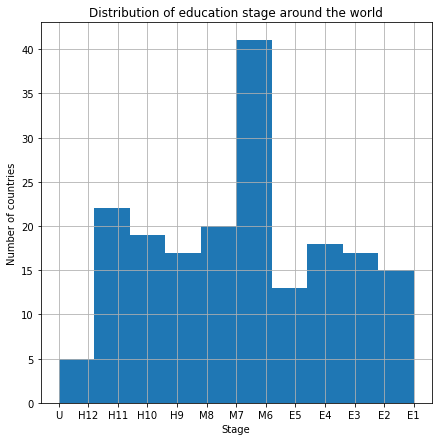

In [19]:
edu_years = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 18]
stages = ["EK", "E1", "E2", "E3", "E4", "E5", "M6", "M7", "M8", "H9", "H10", "H11", "H12", "U"]
    
education_stage_distribution = pd.cut(top_educated, bins=edu_years, labels=stages)
education_stage_distribution.hist(figsize=(7,7));
plt.title("Distribution of education stage around the world");
plt.xlabel("Stage");
plt.ylabel("Number of countries");

From above histogram, we can see that Middle School 6th and 7th grade is where most of the countrie´s population drop their studies.

### From best and worst  countries in terms of education opportunity, Is there any correlation with  Income per capita, Life expectancy and Unemployment indicators?.

In [20]:
united_states = education_df.loc["United States"]

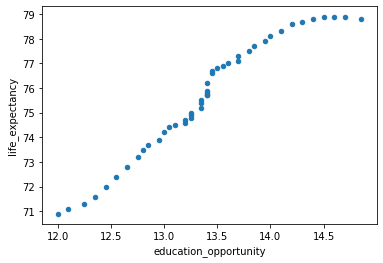

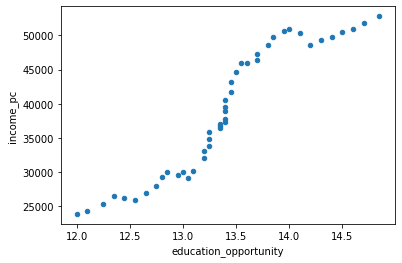

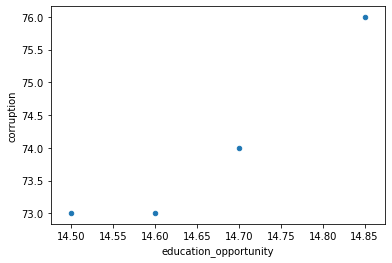

In [21]:
united_states.plot(x="education_opportunity", y="life_expectancy", kind="scatter");
united_states.plot(x="education_opportunity", y="income_pc", kind="scatter");
united_states.plot(x="education_opportunity", y="corruption", kind="scatter");

In [22]:
niger = education_df.loc["Niger"]

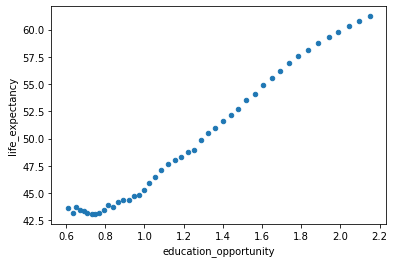

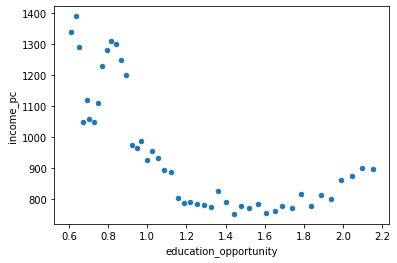

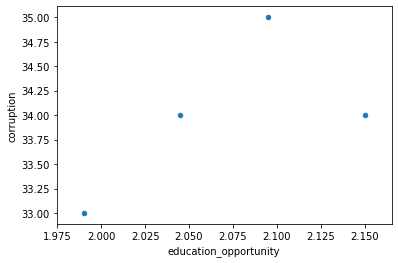

In [23]:
niger.plot(x="education_opportunity", y="life_expectancy", kind="scatter");
niger.plot(x="education_opportunity", y="income_pc", kind="scatter");
niger.plot(x="education_opportunity", y="corruption", kind="scatter");

It´s impossible to determine a conclusion just by comparing correlation between 2 indicators. What we can see from this exploration is:
1. There is a positive correlation between `education_opportunity` and `life_expectancy`. However that does not mean education is a causality of people to live more. There are several more factors such as health access, natural disasters, insecurity level etc.. that could affect life expectancy. Also life expectancy has grown allover the world in recent years as we could see in our education_df timeline.
2. Education level tend to be benefitial for the income per capita of United States, but if we analyse Niger, actually income decreases as the population has more access to education. As the previous point, there are a bunch of additional factors that could contribute to income per capita appart from education , such as foreign investment, work opportunities, urbanization etc.
3. Corruption is the hardest indicator to explore, given that we actually have little amount of data to work with.

### From top 5 most educated countries, Which one did demonstrate the biggest growth in terms of education opportunity in period 1970 - 2015? Which was the most lagging one?

In [24]:
# The rest of our more educated countries

canada = education_df.loc["Canada"]
israel = education_df.loc["Israel"]
japan = education_df.loc["Japan"]
norway = education_df.loc["Norway"]

Lets plot a line chart over time to get some insight of this question.

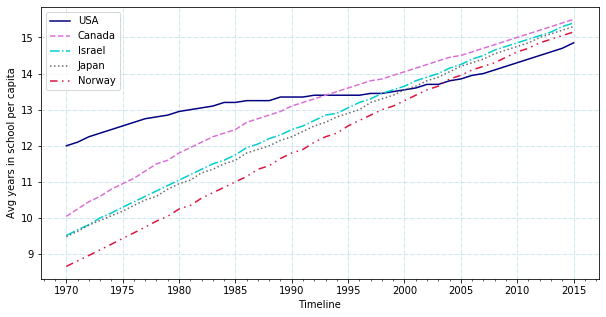

In [35]:
from matplotlib import colors as mcolors
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 5))
plt.plot(united_states.education_opportunity, label="USA", c='navy')
# Add line style for color blind support
plt.plot(canada.education_opportunity, label="Canada", c='orchid', ls='--')
plt.plot(israel.education_opportunity, label="Israel", c='darkturquoise', ls='-.')
plt.plot(japan.education_opportunity, label="Japan", c='dimgrey', ls=':')
plt.plot(norway.education_opportunity, label="Norway", c='crimson', ls=(0,(5,3,1,3,1,3)))
plt.grid(color='lightblue', linestyle='-.', linewidth=0.6)
axes = plt.gca()
# Let´s set timeline ticks every 5 years
axes.xaxis.set_major_locator(ticker.MultipleLocator(5))
axes.xaxis.set_minor_locator(ticker.MultipleLocator(1))
plt.xlabel("Timeline")
plt.ylabel("Avg years in school per capita")
plt.legend()
plt.show()

It´s interesting to see how US has been a protagonist when it comes to education, but looks like there was stagnation from 1985 - 2000. Boost was gained from 2005 onwards.
Also, it´s amazing to see how countries such as Norway has increased their education opportunity by more than 50% during this period.
The good news for these countries is that years spent by their citizens at school tend to increase even more in comming years.


To demonstrate our first impresions, let´s do some calculations.

In [39]:
def calculate_edu_growth(country_df, country_iso):
    '''
        Calculates growth of education opportunity by comparing a given year against previous one.
        It generates a new column called country_iso_growth that represents performed calculation.
        
        country_df: Dataframe to calculate growth
        country_iso: 2 letters ISO identifier for given country
    '''
    growth_col_name = "{}_edu_growth".format(country_iso)
    for i in range(0, len(country_df)):
        # For first year, we have no previous to compare with so growth is zero
        if i == 0:
            growth_value = 0.0
        else:
        # 0 index means first column "educational_opportunity"
            growth_value = country_df.iloc[i, 0] - country_df.iloc[i - 1, 0]
        country_df.loc[country_df.index[i], growth_col_name] = growth_value


In [40]:
us_df = united_states.education_opportunity.to_frame().rename(columns={"education_opportunity" : "us_edu"})
calculate_edu_growth(us_df, "us")
ca_df = canada.education_opportunity.to_frame().rename(columns={"education_opportunity" : "ca_edu"})
calculate_edu_growth(ca_df, "ca")
il_df = israel.education_opportunity.to_frame().rename(columns={"education_opportunity" : "il_edu"})
calculate_edu_growth(il_df, "il")
jp_df = japan.education_opportunity.to_frame().rename(columns={"education_opportunity" : "jp_edu"})
calculate_edu_growth(jp_df, "jp")
no_df = norway.education_opportunity.to_frame().rename(columns={"education_opportunity" : "no_edu"})
calculate_edu_growth(no_df, "no")

With all dataframes of our top 5 countries in place, then let´s merge them all into unique dataframe so we can apply some descriptive statistics on it.

In [48]:
most_educated = pd.merge(us_df, ca_df, left_index=True, right_index=True)
most_educated = most_educated.merge(il_df, left_index=True, right_index=True)
most_educated = most_educated.merge(jp_df, left_index=True, right_index=True)
most_educated = most_educated.merge(no_df, left_index=True, right_index=True)
most_educated

,us_edu,us_growth,ca_edu,ca_growth,il_edu,il_growth,jp_edu,jp_growth,no_edu,no_growth
1970,12.00,0.00,10.045,0.000,9.515,0.000,9.485,0.000,8.660,0.000
1971,12.10,0.10,10.250,0.205,9.675,0.160,9.630,0.145,8.815,0.155
1972,12.25,0.15,10.450,0.200,9.815,0.140,9.805,0.175,8.965,0.150
1973,12.35,0.10,10.600,0.150,10.005,0.190,9.935,0.130,9.120,0.155
1974,12.45,0.10,10.800,0.200,10.140,0.135,10.065,0.130,9.275,0.155
1975,12.55,0.10,10.950,0.150,10.300,0.160,10.190,0.125,9.435,0.160
1976,12.65,0.10,11.100,0.150,10.450,0.150,10.350,0.160,9.590,0.155
1977,12.75,0.10,11.300,0.200,10.600,0.150,10.500,0.150,9.750,0.160
1978,12.80,0.05,11.500,0.200,10.750,0.150,10.600,0.100,9.915,0.165
1979,12.85,0.05,11.600,0.100,10.900,0.150,10.800,0.200,10.050,0.135


In [51]:
most_educated.describe()

,us_edu,us_growth,ca_edu,ca_growth,il_edu,il_growth,jp_edu,jp_growth,no_edu,no_growth
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,13.396739,0.061957,13.137935,0.118587,12.648913,0.127935,12.535000,0.126413,12.075543,0.141087
std,0.678921,0.044950,1.556076,0.044129,1.742537,0.035662,1.739913,0.037737,1.974972,0.039326
min,12.000000,0.000000,10.045000,0.000000,9.515000,0.000000,9.485000,0.000000,8.660000,0.000000
25%,13.012500,0.012500,11.987500,0.100000,11.237500,0.100000,11.100000,0.100000,10.400000,0.100000
50%,13.400000,0.050000,13.350000,0.100000,12.775000,0.150000,12.600000,0.112500,12.175000,0.150000
75%,13.775000,0.100000,14.425000,0.150000,14.112500,0.150000,14.012500,0.150000,13.800000,0.155000
max,14.850000,0.150000,15.500000,0.205000,15.400000,0.200000,15.300000,0.200000,15.150000,0.200000


From Above statistics we can see that Norway has the fastest growth avg with 0.14% year over year, while US has slowest growth with 0.061%.
Canada has the maximum Average of education reported in a given year with 15.5 years of spent at school per capita.
Norway is the country with the minimum level registered of education_opportunity among all with 8.66 years avg.
These results evidence how fast Norway is by growing in education opportunity.

<a id='conclusions'></a>
## Conclusions


To make it clear, all above responses to research questions are merely exploratory. None of them can infer a concrete conclusion about how education moves around the world.
The most difficult part of this work was to reshape data in a way that we could answer to those questions.
A takeaway from this research work is that Education, as any other country indicator is way difficult to measure, process and analyse given that concepts like Economy, Politics, Health among others are factors that affect in some form.